In [1]:
#import libraries
import pandas as pd
import numpy as np
from functions import *
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce


from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler,Normalizer,LabelEncoder
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

In [2]:
#load in the dataset
df = pd.read_csv('./mdata/train.csv')
df.head()

,Date,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,2013-01-01,1115.0,2.0,0.0,0.0,0.0,0.0,a,1.0
1,2013-01-01,379.0,2.0,0.0,0.0,0.0,0.0,a,1.0
2,2013-01-01,378.0,2.0,0.0,0.0,0.0,0.0,a,1.0
3,2013-01-01,377.0,2.0,0.0,0.0,0.0,0.0,a,1.0
4,2013-01-01,376.0,2.0,0.0,0.0,0.0,0.0,a,1.0


In [3]:
#check df shape
df.shape

(637774, 9)

In [4]:
#check for unique count of Store
df.Store.nunique()

1115

In [5]:
#split df into train and test
train = df.iloc[:int(0.7*df.shape[0])]
test = df.iloc[int(0.7*df.shape[0]):]

In [6]:
#check to be sure that every store is represented in train and test
print(train.Store.nunique())
print(test.Store.nunique())

1115
1115


In [7]:
store = pd.read_csv('./mdata/store.csv')
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


## Descriptives and Data Cleaning

### Descriptives

Here, We want to explore the dataset, to understand the dataset better. We will make plots,create tables and a dashboard (using data google studio). Some plots created are:  
- Plot showing sales distribution.
- Heatmap showing column correlations.

Note: The dashboard is available at: https://bit.ly/36HcgSA


### Data Cleaning
Some Cleaning done are:
- Remove all instances where customer count is zero
- Drop DayofWeek and extract new DayofWeek using datetime
- Extract month, year and to columns
- Replace Nan's in sales with the average sales per store
- Replace all nan's in competitiondistance with average competition distance

In [8]:
#join train and store together on Stores

rs_df = pd.merge(train,store,on='Store',suffixes=('', '_y'))

#remove every instance where customer count is zero
rs_df = customer_zero(rs_df)

rs_df.head()

,Date,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
1,2013-01-02,1115.0,3.0,3697.0,305.0,1.0,0.0,0,1.0,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
2,2013-01-03,1115.0,4.0,4297.0,300.0,1.0,0.0,0,1.0,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
3,2013-01-04,1115.0,5.0,4540.0,326.0,1.0,0.0,0,1.0,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
4,2013-01-05,1115.0,6.0,4771.0,339.0,1.0,0.0,0,1.0,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
6,2013-01-07,1115.0,1.0,6905.0,471.0,1.0,1.0,0,1.0,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"


In [9]:
rs_df.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,348356.000000,337879.000000,337923.000000,348356.000000,337857.0,337987.000000,337645.000000,347430.000000,237685.000000,237685.000000,348356.000000,177927.000000,177927.000000
mean,557.808417,3.522296,6810.080288,756.322518,1.0,0.433150,0.197483,5428.885876,7.229081,2008.675537,0.510762,23.592445,2011.763268
std,321.616818,1.728383,3103.982879,401.203030,0.0,0.495512,0.398100,7744.499591,3.207989,6.181617,0.499885,14.135934,1.671903
min,1.000000,1.000000,133.000000,18.000000,1.0,0.000000,0.000000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000
25%,280.000000,2.000000,4720.000000,510.000000,1.0,0.000000,0.000000,720.000000,4.000000,2006.000000,0.000000,13.000000,2011.000000
50%,557.000000,4.000000,6214.000000,668.500000,1.0,0.000000,0.000000,2320.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000
75%,836.000000,5.000000,8186.000000,888.000000,1.0,1.000000,0.000000,6890.000000,10.000000,2013.000000,1.000000,37.000000,2013.000000
max,1115.000000,7.000000,37646.000000,7388.000000,1.0,1.000000,1.000000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


In [10]:
rs_df.groupby(['StoreType']).agg({'Sales': [np.mean, np.max, np.min, np.std, 'count']}).reset_index().head(10)

StoreType        Sales                                      
                    mean     amax    amin          std   count
0         a  6828.099918  35697.0   286.0  3279.395262  182199
1         b  9748.700938  37376.0  1580.0  5240.133108    5972
2         c  6824.564829  30143.0   133.0  3007.844496   44633
3         d  6605.749103  37646.0   538.0  2529.467335  105119

In [11]:
rs_df.groupby(['Assortment']).agg({'Sales': [np.mean, np.max, np.min, np.std, 'count']}).reset_index().head(10)

Assortment        Sales                                      
                     mean     amax    amin          std   count
0          a  6560.341889  37376.0   297.0  2983.978119  179266
1          b  7766.766563  22137.0  1580.0  3650.817535    3230
2          c  7078.241593  37646.0   133.0  3199.666920  155427

In [12]:
rs_df.shape

(348356, 18)

In [13]:
#data cleaning ideas
#- check for null values
#- first drop all unneccesary data
#- make some plots
#- if customers is zero, then sales is zero

Text(0, 0.5, 'Sales')

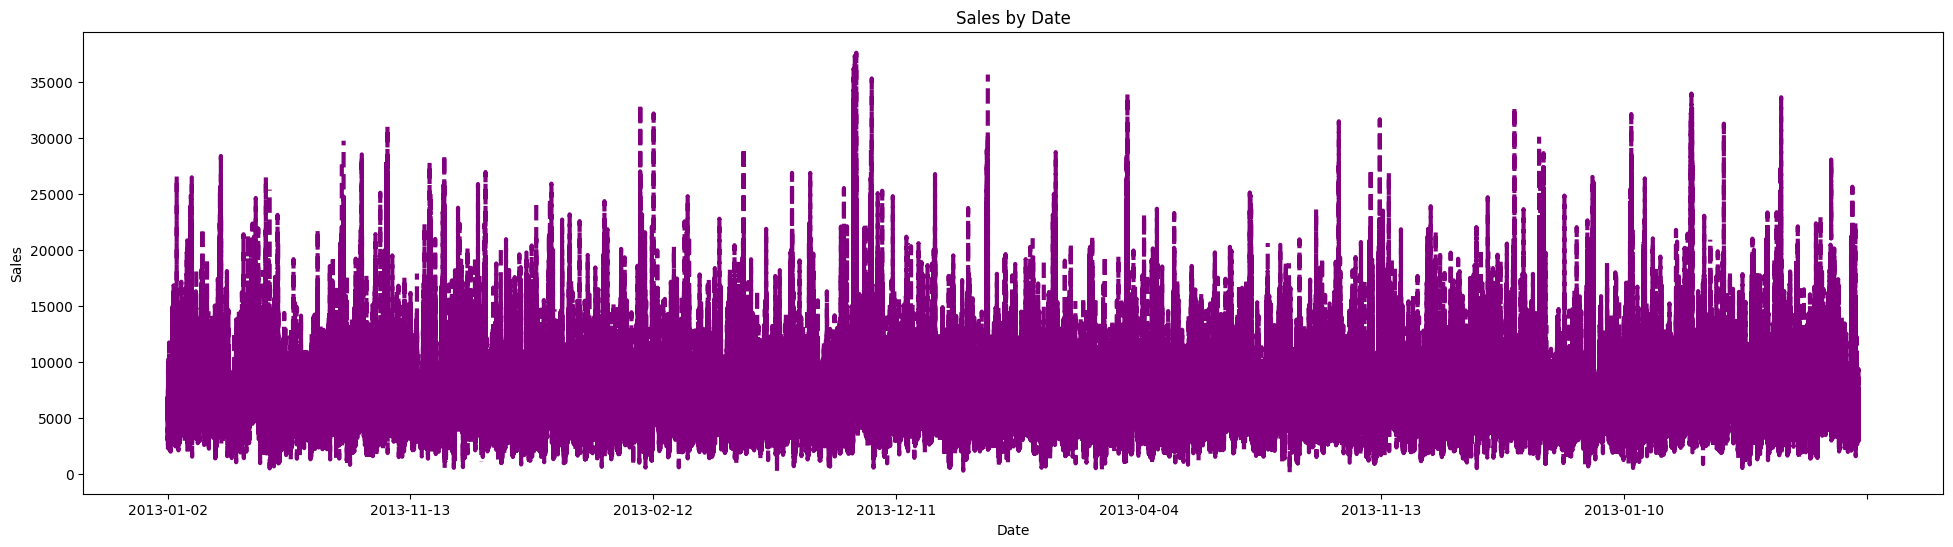

In [14]:
#create time series plot with custom line
rs_df.plot(x='Date', y='Sales',linewidth=3, color='purple', linestyle='dashed', legend=False,figsize=(24,6))

#add title and axis labels to plot

plt.title('Sales by Date')
plt.xlabel('Date')
plt.ylabel('Sales')

#Note that in the plot above -- Stores are mixed

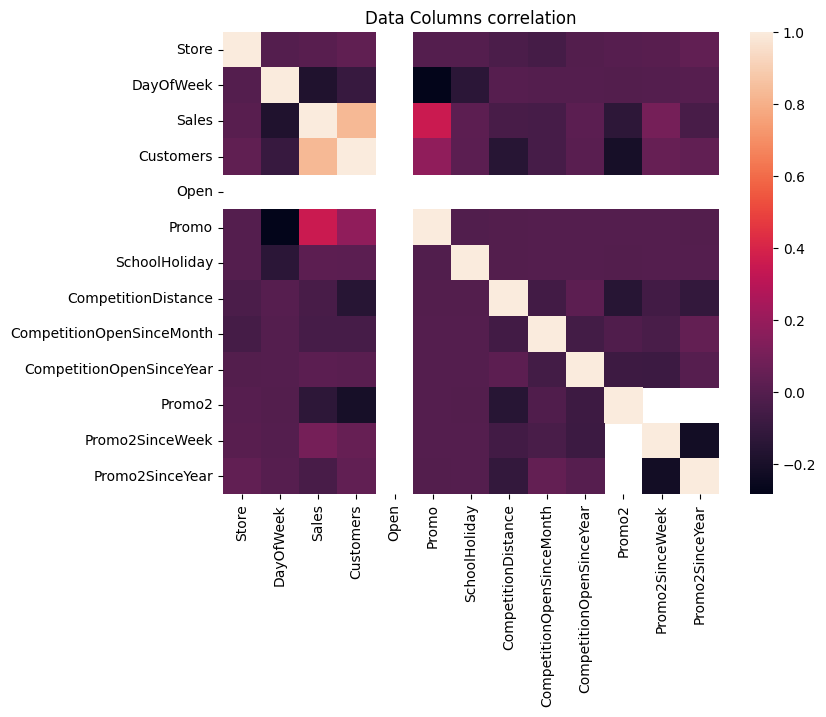

In [15]:
#plot data-column correlations

plt.figure(figsize=(8,6))
plt.title('Data Columns correlation')
sns.heatmap(rs_df.corr())
plt.show()

In [16]:
rs_df.isnull().sum()

Date                              0
Store                             0
DayOfWeek                     10477
Sales                         10433
Customers                         0
Open                          10499
Promo                         10369
StateHoliday                  10575
SchoolHoliday                 10711
StoreType                         0
Assortment                        0
CompetitionDistance             926
CompetitionOpenSinceMonth    110671
CompetitionOpenSinceYear     110671
Promo2                            0
Promo2SinceWeek              170429
Promo2SinceYear              170429
PromoInterval                170429
dtype: int64

In [17]:
#check possible open samples
rs_df.Open.unique()

array([ 1., nan])

In [18]:
#check promo value_counts
rs_df.Promo.value_counts()

0.0    191588
1.0    146399
Name: Promo, dtype: int64

In [19]:
rs_df[['SchoolHoliday']].value_counts()

SchoolHoliday
0.0              270966
1.0               66679
dtype: int64

In [20]:
def fixdateofweek(df):
    #this function drops the datetime column and creates a new one
    df.drop(['DayOfWeek'],axis=1,inplace=True)
    
    df['DayOfWeek'] = pd.to_datetime(df['Date']).dt.dayofweek
    df['month'] = pd.to_datetime(df['Date']).dt.month
    df['year'] = pd.to_datetime(df['Date']).dt.year
    
    df.drop(['Date'],axis=1,inplace=True)
    return df

#fix dateofweek
rs_df = fixdateofweek(rs_df)

In [21]:
def fix_open(df):
    #this function replaces all Nan's in open with 0
    #and nan's in Promocode with 2
    #and SchoolHoliday and StateHoliday with 0
    df['Open'] = df['Open'].fillna(0)
    df['Promo'] = df['Promo'].fillna(2)
    
    df['StateHoliday'] = df['StateHoliday'].fillna('0')   #specifically making this a string
    df['SchoolHoliday'] = df['SchoolHoliday'].fillna(0)
    
    #replace competitor distance with average competitor distance (could also be 0)
    df['CompetitionDistance'] = df['CompetitionDistance'].fillna(int(df['CompetitionDistance'].mean()))
    return df

#replace nan in open columns with zero
rs_df = fix_open(rs_df)

rs_df.head()

,Store,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,DayOfWeek,month,year
1,1115.0,3697.0,305.0,1.0,0.0,0,1.0,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec",2,1,2013
2,1115.0,4297.0,300.0,1.0,0.0,0,1.0,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec",3,1,2013
3,1115.0,4540.0,326.0,1.0,0.0,0,1.0,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec",4,1,2013
4,1115.0,4771.0,339.0,1.0,0.0,0,1.0,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec",5,1,2013
6,1115.0,6905.0,471.0,1.0,1.0,0,1.0,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec",0,1,2013


In [22]:
def fix_sales(df):
    '''This function replaces Nan's in Sales with average sales'''
    #calculate average sales
    df_stats = df.groupby(['Store']).agg({'Sales':'mean'}).reset_index(drop=False)
    
    #join average sales to rs_df
    df = pd.merge(df,df_stats,on='Store',suffixes=('', '_average'))
    
    #replace nan Sales with the mean sales of the Store
    df.loc[df.Sales.isnull(),'Sales'] = df['Sales_average']
    
    df.drop(['Sales_average'],axis=1,inplace=True)
    
    df = df[df['Sales'] > 0]    #drop Sales equals 0
    
    return df

rs_df = fix_sales(rs_df)

rs_df.head()

,Store,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,DayOfWeek,month,year
0,1115.0,3697.0,305.0,1.0,0.0,0,1.0,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec",2,1,2013
1,1115.0,4297.0,300.0,1.0,0.0,0,1.0,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec",3,1,2013
2,1115.0,4540.0,326.0,1.0,0.0,0,1.0,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec",4,1,2013
3,1115.0,4771.0,339.0,1.0,0.0,0,1.0,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec",5,1,2013
4,1115.0,6905.0,471.0,1.0,1.0,0,1.0,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec",0,1,2013


In [23]:
#drop other columns
rs_df = rs_df.drop(['CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Promo2SinceWeek','Promo2SinceYear','PromoInterval'],axis=1)

### Feature Engineering

Encodings:
- One Hot Encode for Assortment.
- Ordinal/Label Encode for StoreType and StateHoliday.

Others:
- Normalizing the Customers and CompetittionDistance colummns

In [24]:
rs_df.head()

,Store,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Promo2,DayOfWeek,month,year
0,1115.0,3697.0,305.0,1.0,0.0,0,1.0,d,c,5350.0,1,2,1,2013
1,1115.0,4297.0,300.0,1.0,0.0,0,1.0,d,c,5350.0,1,3,1,2013
2,1115.0,4540.0,326.0,1.0,0.0,0,1.0,d,c,5350.0,1,4,1,2013
3,1115.0,4771.0,339.0,1.0,0.0,0,1.0,d,c,5350.0,1,5,1,2013
4,1115.0,6905.0,471.0,1.0,1.0,0,1.0,d,c,5350.0,1,0,1,2013


In [25]:
#Encoding
#ordinal_encoder for Assortment
ce_ord = ce.OrdinalEncoder(cols = ['Assortment','StateHoliday'])

#one_hot_encoder for StoreType
ce_one = ce.OneHotEncoder(cols=['StoreType']) 

In [26]:
#set up the column transfomer
ct = ColumnTransformer([
        ('transformer', Normalizer(norm='l1'), ['Customers','CompetitionDistance'])
    ], remainder='passthrough')

### Model Development

Models
- Linear Regression Model/Pipeline (Baseline Model).
- Random Forest
- Gradient Boosted Trees.

In [27]:
#estimate errors
def metric(preds, actuals):
    #preds = preds.reshape(-1)
    #actuals = actuals.reshape(-1)
    assert preds.shape == actuals.shape
    return 100 * np.linalg.norm((actuals - preds) / actuals) / np.sqrt(preds.shape[0])

In [46]:
#split the data into X and y
y = rs_df.Sales
X = rs_df.drop('Sales',axis=1)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

##### Linear Regression

In [47]:
#Build pipeline
pipe_lc = Pipeline([('ordinal_encoder', ce_ord), 
                    ('one_hot',ce_one), 
                    ('transformer', ct),
                    ('linear', LinearRegression())])

#fit the pipeline
pipe_lc.fit(X_train,y_train)

#make predictions
preds_lc = pipe_lc.predict(X_test)

In [48]:
acc = metric(preds_lc,y_test)
print(f'The RMSPE for the Linear Regression Pipeline is {acc}') 

The RMSPE for the Linear Regression Pipeline is 50.28095710534017


##### Random Forest

In [49]:
#instantiate rf model
rf = RandomForestRegressor(max_depth=4, random_state=42, n_estimators=300)

In [50]:
#Build pipeline
pipe_rf = Pipeline([('ordinal_encoder', ce_ord), 
                    ('one_hot',ce_one), 
                    ('transformer', ct),
                    ('rf', rf)])

#fit the pipeline
pipe_rf.fit(X_train,y_train)

#make predictions
preds_rf = pipe_rf.predict(X_test)

In [51]:
acc_rf = metric(preds_rf,y_test)
print(f'The RMSPE for the Linear Regression Pipeline is {acc_rf}') 

The RMSPE for the Linear Regression Pipeline is 48.83985893317713


##### Gradient Boosted Trees

In [52]:
lgbc = lgb.LGBMRegressor(learning_rate=0.1,n_estimators=1000,max_depth=5,num_leaves=50,n_jobs=-1)

In [53]:
#Build pipeline
pipe_gb = Pipeline([('ordinal_encoder', ce_ord), 
                    ('one_hot',ce_one), 
                    ('transformer', ct),
                    ('gbt', lgbc)])

#fit the pipeline
pipe_gb.fit(X_train,y_train)

#make predictions
preds_gb = pipe_gb.predict(X_test)

In [54]:
acc_gb = metric(preds_gb,y_test)
print(f'The RMSPE for the Gradient Boosted Trees Pipeline is {acc_gb}') 

The RMSPE for the Gradient Boosted Trees Pipeline is 21.75445571558905


In [55]:
##### Save Model for pipeline.py
import pickle

filename = './pipeline/gb_pipeline.pkl'
pickle.dump(pipe_gb, open(filename, 'wb'))

#### HyperParameter Tuning / Next Steps

In [38]:
from sklearn.model_selection import GridSearchCV

#apply encoder manually
X_train[['Assortment','StateHoliday']] = ce_ord.fit_transform(X_train[['Assortment','StateHoliday']])

#one_hot_encoder for StoreType
X_train = ce_one.fit_transform(X_train['StoreType']) 

In [ ]:
param_grid = {'n_estimators':[500,800,1000,1200],
              'learning_rate': [0.05, 0.07, 0.1],
              'max_depth':[3,4,5],
              'subsample':[0.8,0.9,1.0],
              'num_leaves':[40,50,70,100]
             }


search = GridSearchCV(lgbc, param_grid, cv=5, n_jobs-1)
search.fit(X_train,y_train)

In [ ]:
#get the best params
search.best_params_

##### Final test with test data

In [56]:
#final test with test data
test.head()

,Date,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
446441,2014-02-05,216.0,3.0,7512.0,905.0,1.0,1.0,0,0.0
446442,2014-02-05,218.0,3.0,5967.0,773.0,NaN,1.0,0,0.0
446443,2014-02-05,219.0,3.0,3679.0,446.0,1.0,1.0,0,0.0
446444,2014-02-05,220.0,3.0,5596.0,722.0,NaN,1.0,0,0.0
446445,2014-02-05,221.0,3.0,5761.0,530.0,1.0,1.0,0,0.0


In [57]:
#merge df with store
ts_df = pd.merge(test,store,on='Store',suffixes=('', '_y'))
    

ts_df = customer_zero(ts_df)
ts_df = fixdateofweek(ts_df)

#replace nan in open columns with zero
ts_df = fix_open(ts_df)
#fix Sales
ts_df = fix_sales(ts_df)
    
#drop other columns
ts_df = ts_df.drop(['CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Promo2SinceWeek','Promo2SinceYear','PromoInterval'],axis=1)

In [58]:
#drop all unneccesary columns
y = ts_df['Sales']  #set the target column
X = ts_df.drop(['Sales'],axis=1)

#make prediction
preds = pipe_gb.predict(X)
score = metric(preds,y)

print(f'The RMSPE for the Gradient Boosted Trees Pipeline is {score}')

The RMSPE for the Gradient Boosted Trees Pipeline is 23.123567720973906
